In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils

import numpy as np

import random

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

seed = 2019

torch.manual_seed(seed)
random.seed(seed)

In [0]:
workerNum = 2
batchNum = 64
dataChannel = 1

num_epochs = 5

channel1 = 128
channel2 = 256
channel3 = 512
channel4 = 1024

nz = 200

lr = 0.001
beta1 = 0.5

In [0]:
trans = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5,),(0.5,))])

dataset = dset.MNIST('./data', train=True, download=True, transform=trans)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchNum, num_workers=workerNum, shuffle=True)

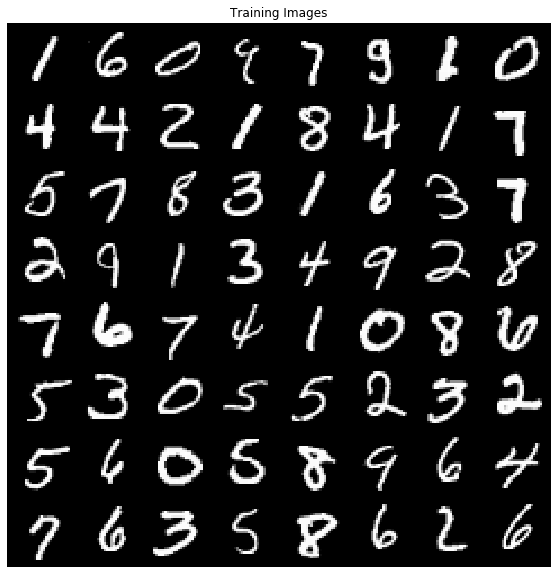

In [84]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].cuda()[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Gen(nn.Module):
    def __init__(self):
        super(Gen, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz,channel2, 7, bias=False),
            nn.BatchNorm2d(channel2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channel2,channel1,4,2,1, bias=False),
            nn.BatchNorm2d(channel1),
            nn.ReLU(inplace=True),
            # nn.ConvTranspose2d(channel2,channel1,4,2,1, bias=False),
            # nn.BatchNorm2d(channel1),
            # nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channel1,1,4,2,1, bias=False),
            #nn.BatchNorm2d(1),
            #nn.ReLU(inplace=True),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.model(x)

In [0]:
class Dis(nn.Module):
    def __init__(self):
        super(Dis, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(dataChannel,channel1,4,2,1, bias=False),
            nn.BatchNorm2d(channel1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(channel1,channel2,4,2,1, bias=False),
            nn.BatchNorm2d(channel2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # nn.Conv2d(channel2,channel3,4,2,1, bias=False),
            # nn.BatchNorm2d(channel3),
            # nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(channel2,1,7, bias=False),
            #nn.BatchNorm2d(1),
            #nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Sigmoid()
        )
            
    def forward(self, x):
        return self.model(x)

In [88]:
netD=Dis().cuda()
#netD.apply(weights_init)
print(netD)

netG=Gen().cuda()
#netG.apply(weights_init)
print(netG)

Dis(
  (model): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)
Gen(
  (model): Sequential(
    (0): ConvTranspose2d(200, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [0]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1).cuda()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [93]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].cuda()
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label).cuda()
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1).cuda()
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 200 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/938]	Loss_D: 0.8634	Loss_G: 2.1308	D(x): 0.5918	D(G(z)): 0.0189 / 0.2648
[0/5][50/938]	Loss_D: 0.3648	Loss_G: 3.0877	D(x): 0.7609	D(G(z)): 0.0376 / 0.0928
[0/5][100/938]	Loss_D: 0.1725	Loss_G: 4.1678	D(x): 0.8917	D(G(z)): 0.0403 / 0.0345
[0/5][150/938]	Loss_D: 0.3906	Loss_G: 4.3192	D(x): 0.7847	D(G(z)): 0.0304 / 0.0314
[0/5][200/938]	Loss_D: 0.3569	Loss_G: 4.0626	D(x): 0.9065	D(G(z)): 0.1498 / 0.0536
[0/5][250/938]	Loss_D: 0.3772	Loss_G: 2.5745	D(x): 0.8915	D(G(z)): 0.1574 / 0.1549
[0/5][300/938]	Loss_D: 0.2031	Loss_G: 3.2908	D(x): 0.8961	D(G(z)): 0.0618 / 0.0832
[0/5][350/938]	Loss_D: 0.2284	Loss_G: 3.5689	D(x): 0.9524	D(G(z)): 0.1246 / 0.0551
[0/5][400/938]	Loss_D: 0.6706	Loss_G: 4.8826	D(x): 0.9282	D(G(z)): 0.3287 / 0.0192
[0/5][450/938]	Loss_D: 0.4891	Loss_G: 4.8822	D(x): 0.9275	D(G(z)): 0.2545 / 0.0206
[0/5][500/938]	Loss_D: 0.1542	Loss_G: 4.1439	D(x): 0.9501	D(G(z)): 0.0848 / 0.0312
[0/5][550/938]	Loss_D: 0.2220	Loss_G: 3.4386	D(x): 0.8962	D(G(z)

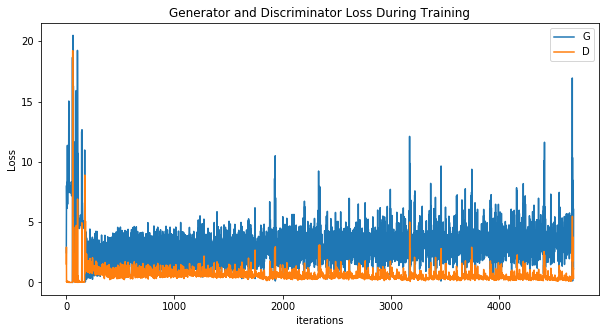

In [91]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

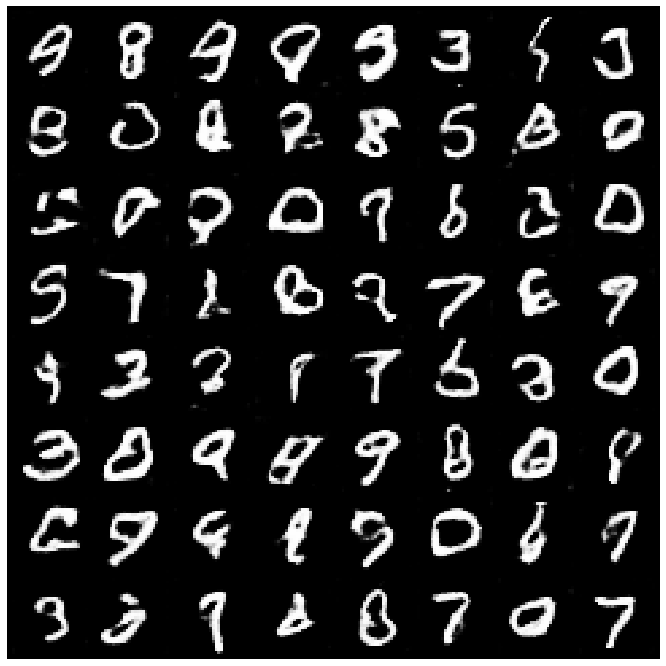

In [92]:
#%%capture
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())